In [12]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as K
import numpy as np
from tensorflow.keras.losses import categorical_crossentropy
from keras.constraints import MaxNorm
from keras.metrics import AUC
from tensorflow.keras import regularizers

### Loading dataset

In [13]:
dmatrix = pd.read_csv('/tf/Classification/Data/BRCA/VII_Sem_Data/dm_red.csv',index_col=0)
dframe = pd.read_csv('/tf/Classification/Data/BRCA/VII_Sem_Data/df_red.csv',index_col=0)

dmatrix = dmatrix.transpose().astype('float64')

dframe.set_index("barcode", inplace=True)
dframe = dframe.loc[dmatrix.index]
dframe.loc[dframe["subtype_PAM50.mRNA"].isna(), "subtype_PAM50.mRNA"] = "No Cancer"
dframe["pam50"], mapping = pd.factorize(dframe["subtype_PAM50.mRNA"])
coded_categories = np.unique(dframe["pam50"])
mapping_dict = {}
count = 0
for i in mapping:
    mapping_dict[i] = count
    count += 1

dmatrix.head()

,AADAC,AOC1,ACADL,ASIC2,ACTA1,ACTC1,ACTN2,ADCY1,ADCY2,ADCY3,...,SFTPA1,PLIN4,GAGE2D,GAGE12J,SHISA9,HOTAIR,FAM196B,GAGE12J,CYP4F30P,LINC00092
TCGA-BH-A1FH-11B-42R-A13Q-07,7.977022,2.584963,6.431469,2.321928,4.485742,3.000000,3.187847,7.440738,7.129199,10.464293,...,2.584963,13.772392,2.807355,3.000000,4.670863,2.584963,6.996862,3.000000,2.584963,5.386545
TCGA-A7-A13F-11A-42R-A12P-07,7.730314,3.698296,8.418371,2.807355,3.085816,2.584963,2.807355,8.032023,5.941961,10.560444,...,3.424317,16.323272,2.807355,2.321928,3.794811,2.807355,7.918793,2.321928,2.807355,5.252726
TCGA-BH-A18V-11A-52R-A12D-07,6.731517,3.229942,6.015107,2.321928,3.976666,2.807355,2.584963,8.259226,7.524064,10.244134,...,3.733007,14.559923,2.321928,2.321928,4.995050,5.200983,5.017018,2.807355,2.321928,5.142230
TCGA-BH-A0BW-11A-12R-A115-07,4.437967,5.720120,4.153416,3.445939,2.321928,3.197425,3.000000,7.330201,6.046105,10.534363,...,2.807355,11.629675,3.000000,2.321928,4.650989,5.266333,6.231342,3.000000,2.584963,5.233647
TCGA-BH-A0C3-11A-23R-A12P-07,3.688863,3.210514,5.261952,2.584963,2.807355,2.807355,3.000000,10.688053,7.566849,10.365280,...,5.336033,9.482368,3.000000,2.321928,4.472260,5.084200,9.522582,2.807355,2.584963,4.498308


### Splitting dataset into train and test set

In [14]:
inputM = dmatrix.to_numpy()
labels = dframe['pam50'].to_numpy()
labels2d = tf.keras.utils.to_categorical(labels)

x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(
        np.array(inputM), np.array(labels2d), test_size = 0.10, random_state = 27)

x_valid = x_test
y_valid = y_test
# x_train, x_valid, y_train, y_valid = sklearn.model_selection.train_test_split(
#         x_train, y_train, test_size=(1/9))

print(inputM.shape) ## patients x number of genes
print(x_test.shape, x_valid.shape, x_train.shape)
print(np.sum(y_valid, 0))
print(np.sum(y_test, 0))
print(np.sum(y_train, 0))

(574, 1519)
(58, 1519) (58, 1519) (516, 1519)
[11. 13. 24. 10.]
[11. 13. 24. 10.]
[102.  88. 209. 117.]


### Building a subnetwork with features from the S set (Train Phase)

In [15]:
def build_a_subnetwork(inputShape, prevModel):
    
    regulariser_const = 0.001
    hidden1_nodes = 100
    hidden2_nodes = 50
    hidden3_nodes = 100
#     hidden4_nodes = 10
    subtypes = 4
    
    if(prevModel != None):
        
        layer0_wts = (prevModel.layers[0].weights[0]).numpy()
        layer1_wts = tf.constant_initializer((prevModel.layers[1].weights[0]).numpy())
        layer2_wts = tf.constant_initializer((prevModel.layers[2].weights[0]).numpy())
#         layer3_wts = tf.constant_initializer((prevModel.layers[3].weights[0]).numpy())
        
        initializer = tf.keras.initializers.GlorotNormal()  ## Xavier initialization
        values = initializer(shape=(1, hidden1_nodes)).numpy() ## shape is (1, number of nodes in first hidden layer)
        
        layer0_wts_afterAddingFeature = np.concatenate((layer0_wts, values), axis = 0)

        layer0_wts  = tf.constant_initializer(layer0_wts_afterAddingFeature)
        
        print("layer_0 weights shape ",layer0_wts_afterAddingFeature.shape,"\n")
        
    else:
        
        layer0_wts = tf.keras.initializers.GlorotNormal()
        layer1_wts = tf.keras.initializers.GlorotNormal()
        layer2_wts = tf.keras.initializers.GlorotNormal()
#         layer3_wts = tf.keras.initializers.GlorotNormal()
        
    
#     prevWeightMatrix = prevWeights.numpy()
    
#     initializer = tf.keras.initializers.GlorotUniform()  ## Xavier initialization
#     values = initializer(shape=(1, 3)).numpy() ## shape is (1, number of nodes in first hidden layer)
    
#     curWtMatrix = np.concatenate((prevWeightMatrix, values), 0)
#     init = tf.constant_initializer(curWtMatrix[1:])
    
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(hidden1_nodes, use_bias=False, activation=tf.nn.relu, input_shape=(inputShape,), kernel_initializer=layer0_wts),  # kernel regulariser are applied to weights
        tf.keras.layers.Dense(hidden2_nodes, use_bias=False, activation=tf.nn.relu, kernel_initializer=layer1_wts),  ## as per research paper we have to take lp regularisation where p = 2
        tf.keras.layers.Dense(hidden3_nodes, use_bias=False, activation=tf.nn.relu, kernel_initializer=layer2_wts),
#         tf.keras.layers.Dense(hidden4_nodes, activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l2(regulariser_const), kernel_initializer=layer3_wts),
        tf.keras.layers.Dense(subtypes, activation='softmax')
    ])
    
    return model

### Selecting new feature from the C set (Selection Phase)

In [16]:
def build_a_subnetwork_with_dropout(inputShape, prevModel):
    
    regulariser_const = 0.001
    hidden1_nodes = 100
    hidden2_nodes = 50
    hidden3_nodes = 100
#     hidden4_nodes = 10
    subtypes = 4
    
    if(prevModel != None):
        
        layer0_wts = (prevModel.layers[0].weights[0]).numpy()
        layer1_wts = tf.constant_initializer((prevModel.layers[1].weights[0]).numpy())
        layer2_wts = tf.constant_initializer((prevModel.layers[2].weights[0]).numpy())
#         layer3_wts = tf.constant_initializer((prevModel.layers[3].weights[0]).numpy())
        
        initializer = tf.keras.initializers.GlorotNormal()  ## Xavier initialization
        values = initializer(shape=(1, hidden1_nodes)).numpy() ## shape is (1, number of nodes in first hidden layer)
        
        layer0_wts_afterAddingFeature = np.concatenate((layer0_wts, values), axis = 0)

        layer0_wts  = tf.constant_initializer(layer0_wts_afterAddingFeature)
        
    else:
        
        layer0_wts = tf.keras.initializers.GlorotNormal()
        layer1_wts = tf.keras.initializers.GlorotNormal()
        layer2_wts = tf.keras.initializers.GlorotNormal()
#         layer3_wts = tf.keras.initializers.GlorotNormal()
        
    
#     prevWeightMatrix = prevWeights.numpy()
    
#     initializer = tf.keras.initializers.GlorotUniform()  ## Xavier initialization
#     values = initializer(shape=(1, 3)).numpy() ## shape is (1, number of nodes in first hidden layer)
    
#     curWtMatrix = np.concatenate((prevWeightMatrix, values), 0)
#     init = tf.constant_initializer(curWtMatrix[1:])
    
    model = tf.keras.Sequential([
#         tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(hidden1_nodes, use_bias=False, activation=tf.nn.relu, input_shape=(inputShape,), kernel_initializer=layer0_wts),  # kernel regulariser are applied to weights
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(hidden2_nodes, use_bias=False, activation=tf.nn.relu, kernel_initializer=layer1_wts),  ## as per research paper we have to take lp regularisation where p = 2
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(hidden3_nodes, use_bias=False, activation=tf.nn.relu, kernel_initializer=layer2_wts),
        tf.keras.layers.Dropout(0.3),
#         tf.keras.layers.Dense(hidden4_nodes, activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l2(regulariser_const), kernel_initializer=layer3_wts),
#         tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(subtypes, activation='softmax')
    ])
    
    return model

In [17]:
from numpy import linalg as LA
def getNorm(grads):
    
    return LA.norm(grads)

In [18]:
def step(trainX, trainY, temp_model):
    
    opt = tf.keras.optimizers.Adagrad(lr=0.01)
    
    with tf.GradientTape() as tape:
        pred = temp_model(trainX)
        loss = categorical_crossentropy(trainY, pred)
        
    grads = tape.gradient(loss, temp_model.trainable_variables)
    opt.apply_gradients(zip(grads, temp_model.trainable_variables))
    
    return grads

In [19]:
import time
## arguments of the function are numpy arrays
def selectNewFeature(model, C_x, C_y, C_size, S_x, S_y, S_size):
    
    maxSoFar = float('-inf')
    
    for i in range(C_size):
        
        temp_S_x = S_x;
        temp_S_y = S_y;
        
#       prevWeights = model.layer[0].weights[0]
        temp_model = build_a_subnetwork_with_dropout(S_size+1, model)
        
 
        columnToAdd = C_x[:, i].reshape(-1, 1)    
        
        temp_S_x = np.append(temp_S_x, columnToAdd, axis = 1)
        
        gradSum = np.zeros((100,))   ## size  (number of nodes in first hidden layer,)
        
        EPOCHS = 1
        BS = 64
        numUpdates = int(temp_S_x.shape[0] / BS)

        # loop over the number of epochs
        for epoch in range(0, EPOCHS):
            # show the current epoch number
#             print("[INFO] starting epoch {}/{}...".format(
#                 epoch + 1, EPOCHS), end="")
            
            epochStart = time.time()
            
            for j in range(0, numUpdates):
                # determine starting and ending slice indexes for the current
                # batch
                start = j * BS
                end = start + BS

                grads = step(temp_S_x[start:end], temp_S_y[start:end], temp_model)

                gradSum = np.add((grads[0][S_size]).numpy(), gradSum)

            # show timing information for the epoch
#             epochEnd = time.time()
#             elapsed = (epochEnd - epochStart) / 60.0
#             print("took {:.4} minutes".format(elapsed))
        gradSum = gradSum / (EPOCHS*numUpdates)
        
        
        normOfNewWt = getNorm(gradSum)
        print("Norm of ",i,"th feature computed\n")
        
#         print("norm\n", normOfNewWt)
#         break
        
        if(normOfNewWt > maxSoFar):
            maxSoFar = normOfNewWt
            featureToAdd = i
            feature =  C_x[:, i].reshape(-1, 1)
        
#         temp_S_x.pop()
#         temp_S_y.pop()
    
    
    return featureToAdd, feature;

### Plotting

In [20]:
import matplotlib.pyplot as plt
def plot(history):
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

### Main Loop

In [21]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Epoch 1/10
17/17 [==============================] - 2s 55ms/step - loss: 1.3669 - accuracy: 0.4237 - auc: 0.6037 - f1_m: 0.0000e+00 - val_loss: 1.3503 - val_accuracy: 0.4138 - val_auc: 0.6034 - val_f1_m: 0.0000e+00
Epoch 2/10
17/17 [==============================] - 0s 10ms/step - loss: 1.3564 - accuracy: 0.3821 - auc: 0.5810 - f1_m: 0.0000e+00 - val_loss: 1.3397 - val_accuracy: 0.4138 - val_auc: 0.5977 - val_f1_m: 0.0000e+00
Epoch 3/10
17/17 [==============================] - 0s 11ms/step - loss: 1.3318 - accuracy: 0.4194 - auc: 0.6290 - f1_m: 0.0000e+00 - val_loss: 1.3332 - val_accuracy: 0.4138 - val_auc: 0.5920 - val_f1_m: 0.0000e+00
Epoch 4/10
17/17 [==============================] - 0s 29ms/step - loss: 1.3205 - accuracy: 0.4275 - auc: 0.6352 - f1_m: 0.0000e+00 - val_loss: 1.3285 - val_accuracy: 0.4138 - val_auc: 0.5920 - val_f1_m: 0.0000e+00
Epoch 5/10
17/17 [==============================] - 0s 14ms/step - loss: 1.3169 - accuracy: 0.4243 - auc: 0.6319 - f1_m: 0.0000e+00 - val_lo

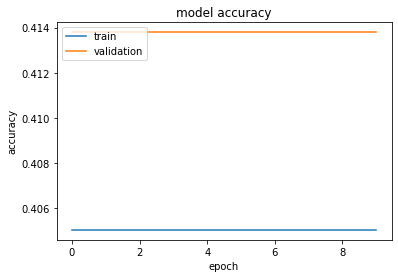

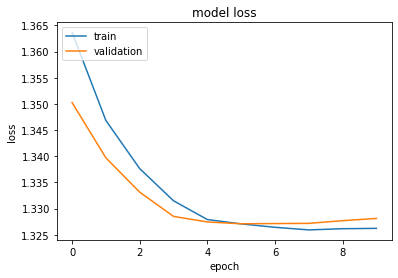

[<tf.Variable 'dense_22692/kernel:0' shape=(1, 100) dtype=float32, numpy=
array([[-7.79976398e-02,  8.81926939e-02,  7.60015324e-02,
         6.93474263e-02, -2.22587865e-02, -1.24109194e-01,
        -1.61781982e-02, -1.27430350e-01,  3.48974788e-03,
        -1.54649734e-01, -3.15537378e-02,  2.88147271e-01,
         2.50649184e-01, -8.96033816e-05, -4.53152061e-02,
         3.64276767e-02, -9.83713865e-02,  1.69256046e-01,
        -1.59522787e-01, -2.43932232e-01, -1.13393115e-02,
        -2.56327186e-02, -1.91757113e-01,  3.55583094e-02,
        -1.16436683e-01,  6.92014098e-02,  1.30255044e-01,
         6.07651696e-02,  2.25199595e-01,  6.58644140e-02,
        -2.43587628e-01,  1.04551233e-01,  2.93293685e-01,
         1.89852968e-01,  1.57279938e-01,  1.87083825e-01,
        -3.46900267e-03,  5.97032979e-02, -8.09834525e-03,
        -1.40778616e-01, -3.16648446e-02, -7.00746998e-02,
        -3.87537628e-02,  1.23493291e-01,  4.95437980e-02,
         1.35429343e-02,  2.80651867e-01,

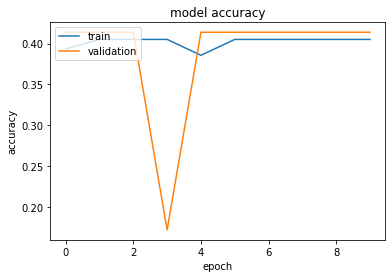

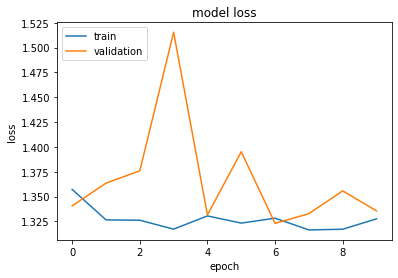

[<tf.Variable 'dense_28772/kernel:0' shape=(2, 100) dtype=float32, numpy=
array([[-7.79976398e-02,  8.81926939e-02,  7.60015324e-02,
         5.80161735e-02, -2.22587865e-02, -1.24109194e-01,
        -1.61781982e-02, -1.38512835e-01,  4.35688952e-03,
        -1.54649734e-01, -3.15537378e-02,  2.88147271e-01,
         2.50649184e-01, -8.96033816e-05, -4.53152061e-02,
         3.64276767e-02, -9.81029719e-02,  1.75872192e-01,
        -1.63945332e-01, -2.50981152e-01, -1.22830886e-02,
        -2.56327186e-02, -1.91757113e-01,  3.63069810e-02,
        -1.16436683e-01,  6.92014098e-02,  1.29600972e-01,
         6.07651696e-02,  2.25199595e-01,  6.58644140e-02,
        -2.46366963e-01,  1.05513319e-01,  2.95684218e-01,
         1.91829950e-01,  1.57579765e-01,  1.87083825e-01,
        -3.46900267e-03,  5.58639243e-02, -1.04204211e-02,
        -1.40778616e-01, -3.22034806e-02, -7.00746998e-02,
        -4.62586097e-02,  1.23493291e-01,  4.95437980e-02,
         1.57155804e-02,  2.80651867e-01,

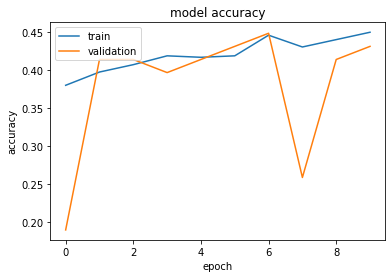

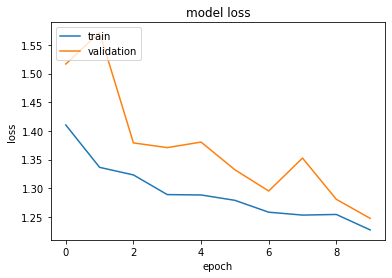

[<tf.Variable 'dense_34848/kernel:0' shape=(3, 100) dtype=float32, numpy=
array([[-7.79976398e-02,  8.81926939e-02,  7.60015324e-02,
         5.87868616e-02, -1.83748025e-02, -1.24566637e-01,
        -1.61781982e-02, -1.39878064e-01,  9.12455027e-04,
        -1.54649734e-01, -3.19726802e-02,  2.88941741e-01,
         2.50649184e-01, -8.96033816e-05, -4.53152061e-02,
         3.64276767e-02, -9.86940041e-02,  1.75872192e-01,
        -1.66983470e-01, -2.52537221e-01, -1.22830886e-02,
        -2.56327186e-02, -1.87738448e-01,  3.51270176e-02,
        -1.16436683e-01,  6.92014098e-02,  1.27690539e-01,
         6.07651696e-02,  2.25199595e-01,  6.55834079e-02,
        -2.46330068e-01,  1.01676449e-01,  2.93439358e-01,
         1.87049702e-01,  1.57579765e-01,  1.83057383e-01,
        -3.46900267e-03,  5.02164662e-02, -1.53643126e-02,
        -1.41081363e-01, -3.23137976e-02, -7.00746998e-02,
        -4.54161055e-02,  1.23493291e-01,  4.94303405e-02,
         1.57155804e-02,  2.80651867e-01,

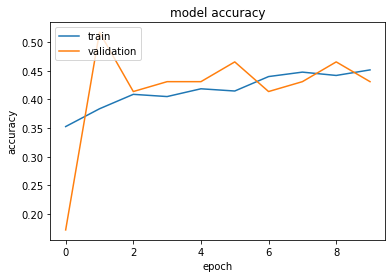

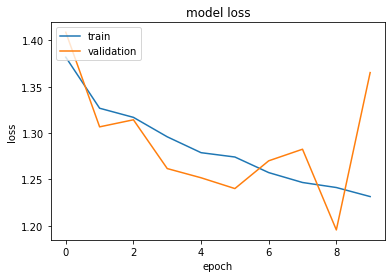

[<tf.Variable 'dense_40920/kernel:0' shape=(4, 100) dtype=float32, numpy=
array([[-7.79976398e-02,  8.81926939e-02,  7.60015324e-02,
         5.87868616e-02, -1.83748025e-02, -1.24566637e-01,
        -1.61781982e-02, -1.39878064e-01, -1.32443686e-03,
        -1.54649734e-01, -3.35117020e-02,  2.86237270e-01,
         2.50649184e-01, -8.96033816e-05, -4.53152061e-02,
         3.64276767e-02, -9.85444263e-02,  1.75545365e-01,
        -1.67409763e-01, -2.55134076e-01, -1.36108184e-02,
        -2.56327186e-02, -1.87827736e-01,  3.36193740e-02,
        -1.16436683e-01,  6.92014098e-02,  1.26639739e-01,
         6.07651696e-02,  2.26962492e-01,  6.55834079e-02,
        -2.46861205e-01,  9.98718515e-02,  2.90429056e-01,
         1.86372533e-01,  1.57827660e-01,  1.80040196e-01,
        -3.46900267e-03,  4.63141091e-02, -1.56149045e-02,
        -1.41849816e-01, -3.24220955e-02, -7.00746998e-02,
        -4.59642187e-02,  1.23493291e-01,  4.86636013e-02,
         1.57155804e-02,  2.80651867e-01,

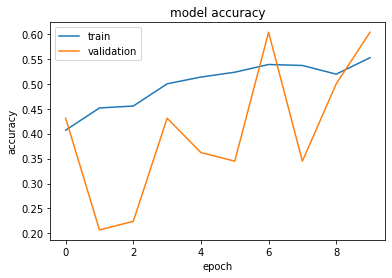

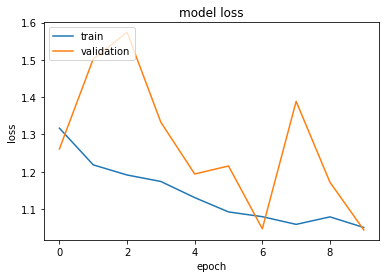

[<tf.Variable 'dense_46988/kernel:0' shape=(5, 100) dtype=float32, numpy=
array([[-7.79976398e-02,  8.51402655e-02,  7.28581250e-02,
         6.07863441e-02, -1.83748025e-02, -1.24566637e-01,
        -1.61781982e-02, -1.39878064e-01, -1.47063052e-03,
        -1.54649734e-01, -3.22364196e-02,  2.84000665e-01,
         2.50649184e-01, -8.96033816e-05, -4.53152061e-02,
         3.62890251e-02, -9.79893133e-02,  1.72012150e-01,
        -1.71305284e-01, -2.56244510e-01, -1.63781159e-02,
        -2.56327186e-02, -1.87827736e-01,  2.89786067e-02,
        -1.16436683e-01,  6.92014098e-02,  1.26639739e-01,
         6.07651696e-02,  2.28809491e-01,  6.53770864e-02,
        -2.51074582e-01,  1.00545950e-01,  2.98217624e-01,
         1.88054204e-01,  1.54024348e-01,  1.78261146e-01,
        -3.46900267e-03,  4.73626629e-02, -1.56149045e-02,
        -1.44975841e-01, -3.38124596e-02, -7.00746998e-02,
        -4.69412431e-02,  1.23493291e-01,  4.88668047e-02,
         1.57155804e-02,  2.80651867e-01,

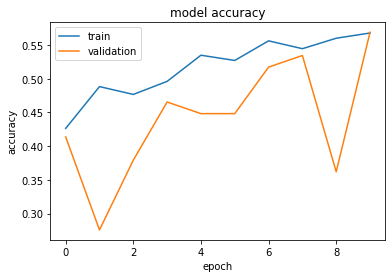

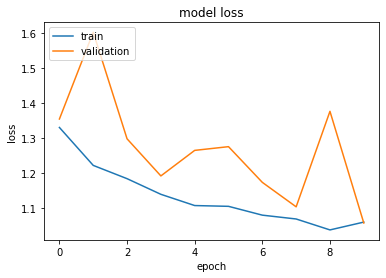

[<tf.Variable 'dense_53052/kernel:0' shape=(6, 100) dtype=float32, numpy=
array([[-7.79976398e-02,  8.07627887e-02,  6.74902722e-02,
         5.90444803e-02, -1.83748025e-02, -1.24566637e-01,
        -1.19509855e-02, -1.37452364e-01, -1.10022491e-03,
        -1.54649734e-01, -3.26645337e-02,  2.80994385e-01,
         2.50649184e-01, -8.96033816e-05, -4.53174785e-02,
         3.49384286e-02, -9.54439119e-02,  1.70778364e-01,
        -1.74761504e-01, -2.57691503e-01, -1.76644884e-02,
        -2.56327186e-02, -1.87827736e-01,  2.42994130e-02,
        -1.16436683e-01,  6.92014098e-02,  1.26639739e-01,
         5.66190332e-02,  2.28809491e-01,  6.53770864e-02,
        -2.54572332e-01,  9.78002697e-02,  3.00842166e-01,
         1.88378781e-01,  1.50905937e-01,  1.76112920e-01,
        -3.46900267e-03,  4.82714362e-02, -1.56149045e-02,
        -1.44975841e-01, -3.27445976e-02, -7.08904341e-02,
        -5.22469692e-02,  1.23493291e-01,  4.53431047e-02,
         1.57155804e-02,  2.80651867e-01,

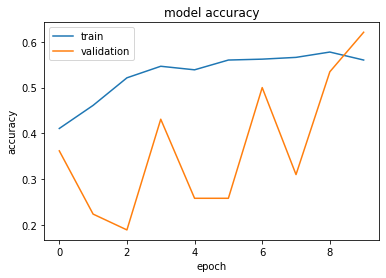

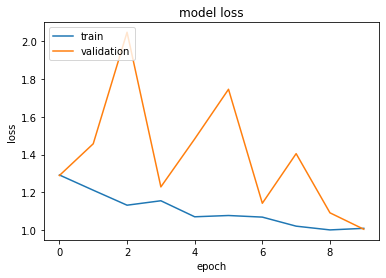

[<tf.Variable 'dense_59112/kernel:0' shape=(7, 100) dtype=float32, numpy=
array([[-7.79976398e-02,  7.94495493e-02,  6.68246523e-02,
         5.47611415e-02, -1.90324765e-02, -1.24566637e-01,
        -1.20625328e-02, -1.40238836e-01, -1.20375317e-03,
        -1.54649734e-01, -3.18152308e-02,  2.78498590e-01,
         2.50649184e-01, -5.79071173e-04, -4.50318195e-02,
         3.49384286e-02, -9.36849639e-02,  1.68620378e-01,
        -1.75179526e-01, -2.61375129e-01, -1.83945093e-02,
        -2.56327186e-02, -1.87827736e-01,  2.23198868e-02,
        -1.16436683e-01,  6.92014098e-02,  1.26639739e-01,
         5.37148789e-02,  2.28809491e-01,  6.53770864e-02,
        -2.56848276e-01,  9.80245546e-02,  3.02820325e-01,
         1.88799307e-01,  1.48493588e-01,  1.76112920e-01,
        -4.04384360e-03,  5.02379015e-02, -1.56149045e-02,
        -1.44975841e-01, -3.27856392e-02, -7.08904341e-02,
        -5.22469692e-02,  1.23493291e-01,  4.39360589e-02,
         1.57155804e-02,  2.80651867e-01,

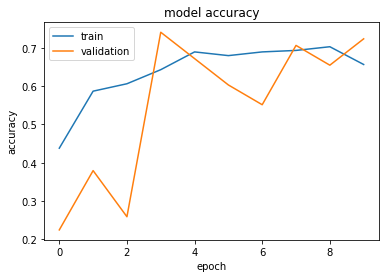

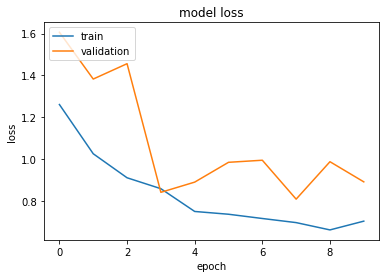

[<tf.Variable 'dense_65168/kernel:0' shape=(8, 100) dtype=float32, numpy=
array([[-7.79976398e-02,  8.47087428e-02,  6.50842190e-02,
         5.32310940e-02, -1.83737427e-02, -1.24566637e-01,
        -1.74130984e-02, -1.47756889e-01, -1.20375317e-03,
        -1.54649734e-01, -2.99039874e-02,  2.76875407e-01,
         2.50649184e-01, -5.79071173e-04, -4.78919260e-02,
         3.49384286e-02, -9.50481370e-02,  1.70000702e-01,
        -1.77844226e-01, -2.64459103e-01, -1.98624060e-02,
        -2.57714670e-02, -1.87827736e-01,  2.02200282e-02,
        -1.16467789e-01,  6.92014098e-02,  1.26639739e-01,
         5.37148789e-02,  2.28809491e-01,  6.66772276e-02,
        -2.56394327e-01,  9.80245546e-02,  3.04800034e-01,
         1.88074738e-01,  1.52101114e-01,  1.76112920e-01,
        -4.04384360e-03,  5.00871502e-02, -1.56149045e-02,
        -1.44975841e-01, -3.67550291e-02, -7.32836723e-02,
        -5.50424196e-02,  1.23493291e-01,  4.23915312e-02,
         1.57155804e-02,  2.80651867e-01,

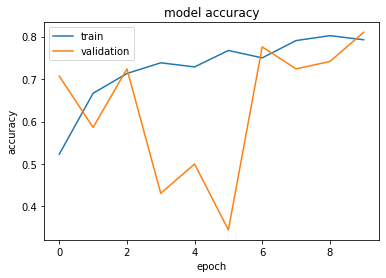

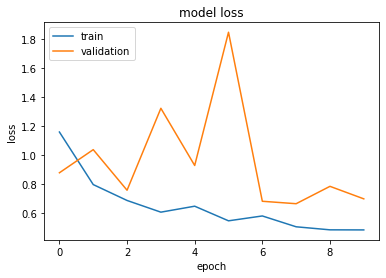

[<tf.Variable 'dense_71220/kernel:0' shape=(9, 100) dtype=float32, numpy=
array([[-7.79976398e-02,  9.08597261e-02,  6.46901876e-02,
         5.29239066e-02, -1.84984617e-02, -1.24566637e-01,
        -2.16944069e-02, -1.52891159e-01, -1.20375317e-03,
        -1.54649734e-01, -3.32290791e-02,  2.78341621e-01,
         2.50649184e-01, -5.79071173e-04, -4.64505292e-02,
         3.49384286e-02, -9.87770781e-02,  1.72622517e-01,
        -1.77179590e-01, -2.71843284e-01, -1.90319661e-02,
        -2.57714670e-02, -1.87827736e-01,  2.35654153e-02,
        -1.16467789e-01,  6.92014098e-02,  1.26639739e-01,
         5.37148789e-02,  2.28809491e-01,  6.66730851e-02,
        -2.55458474e-01,  9.84969214e-02,  3.00872713e-01,
         1.87225133e-01,  1.53771028e-01,  1.76076204e-01,
        -4.04384360e-03,  4.95773926e-02, -1.56149045e-02,
        -1.44975841e-01, -4.13267910e-02, -7.33827129e-02,
        -5.84142059e-02,  1.23493291e-01,  4.17732261e-02,
         1.57155804e-02,  2.80651867e-01,

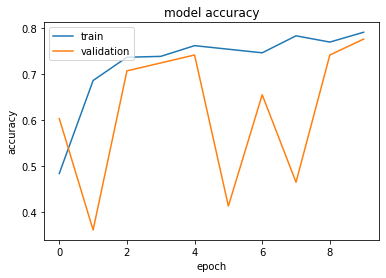

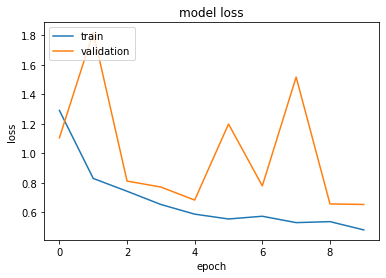

[<tf.Variable 'dense_77268/kernel:0' shape=(10, 100) dtype=float32, numpy=
array([[-7.79976398e-02,  9.53448564e-02,  6.46453500e-02,
         4.89729941e-02, -1.49191841e-02, -1.24566637e-01,
        -2.44945846e-02, -1.52891159e-01, -2.28606118e-03,
        -1.54649734e-01, -3.28767635e-02,  2.80872732e-01,
         2.50649184e-01, -5.79071173e-04, -4.40228209e-02,
         3.49384286e-02, -1.03454202e-01,  1.77789122e-01,
        -1.74589843e-01, -2.74830580e-01, -1.90319661e-02,
        -2.57714670e-02, -1.87827736e-01,  2.65639946e-02,
        -1.15956746e-01,  6.92014098e-02,  1.26639739e-01,
         5.37148789e-02,  2.28809491e-01,  6.66730851e-02,
        -2.54258394e-01,  1.00021929e-01,  2.96949983e-01,
         1.83796585e-01,  1.56477302e-01,  1.76076204e-01,
        -4.04384360e-03,  4.96655144e-02, -1.56149045e-02,
        -1.44975841e-01, -4.30023670e-02, -7.55247697e-02,
        -6.51837587e-02,  1.23493291e-01,  4.16487455e-02,
         1.57155804e-02,  2.80651867e-01

In [22]:
from keras.callbacks import EarlyStopping
def dnp():
    
    S_size = 1
    C_size = (x_train.shape[1])
    S_x = np.ones((x_train.shape[0], 1))
    S_y = y_train
    C_x = x_train
    C_y = y_train
    
    x_val_curr = np.ones((x_valid.shape[0], 1))
    x_val_rem = x_valid
    
    x_test_curr = np.ones((x_valid.shape[0], 1))
    x_test_rem = x_test
    
    k = 10
    
    prevModel = None
    
    ## prevWeightMatrix = np.zeros((1, 100))  ## shape is (1, number of nodes in first hidden layer)
    
    while(True): ## S_size <= k
        
        model = build_a_subnetwork(S_size, prevModel)
        
        opt = keras.optimizers.Adagrad(learning_rate=0.01)
        model.compile(optimizer=opt, loss=tf.keras.losses.CategoricalCrossentropy(), metrics=["accuracy", "AUC", f1_m])
        model.fit(S_x, S_y, epochs = 10, validation_data=(x_val_curr, y_valid)) 
        ## callbacks = EarlyStopping(monitor="val_loss", verbose = 1, patience = 2)
        
        plot(model.history)
        
        ##print(model.summary())
        
        ## prevWeightMatrix = model.layers[0].weights[0]
        
        prevModel = model
        
        print(model.layers[0].weights)
        
#         print(prevWeightMatrix)
        
        featureToAdd, feature = selectNewFeature(model, C_x, C_y, C_size, S_x, S_y, S_size)
        
        print("Feature to add \n", featureToAdd)
        
#         break
        
        S_size += 1;
        C_size -= 1;
        
        if(S_size > k):
            return model, S_x, x_test_curr, x_val_curr
        
        
        ## Updating x_train
        columnToAdd = C_x[:, featureToAdd].reshape(-1, 1)
        
        S_x = np.append(S_x, columnToAdd, axis = 1)
        C_x = np.delete(C_x, featureToAdd, 1)
        
        ## Updating x_valid
        validColmnToAdd = x_val_rem[:, featureToAdd].reshape(-1, 1)
        
        x_val_curr = np.append(x_val_curr, validColmnToAdd, axis = 1)
        x_val_rem = np.delete(x_val_rem, featureToAdd, 1)
        
        ## Updating x_test 
        testColmnToAdd = x_test_rem[:, featureToAdd].reshape(-1, 1)
        
        x_test_curr = np.append(x_test_curr, testColmnToAdd, axis = 1)
        x_test_rem = np.delete(x_test_rem, featureToAdd, 1)
        
        
#     return model, x_test_curr
        
model, S_x, x_test_curr, x_val_curr = dnp()

### Saving the model

In [31]:
model.save("genomics_model")
%store S_x
%store x_test_curr
%store x_val_curr

INFO:tensorflow:Assets written to: genomics_model/assets
Stored 'S_x' (ndarray)
Stored 'x_test_curr' (ndarray)
Stored 'x_val_curr' (ndarray)


### Evaluating Model

In [27]:
temp = x_test_curr
print(temp.shape)
model.evaluate(temp, y_test, verbose = 2)

(58, 10)
2/2 - 0s - loss: 0.6533 - accuracy: 0.7759 - auc: 0.9263 - f1_m: 0.7806


[0.6532854437828064,
 0.7758620977401733,
 0.9262782335281372,
 0.7805788516998291]

### Loading the saved model

In [ ]:
reconstructed_model = keras.models.load_model("genomics_model")
%store -r S_x
%store -r x_test_curr
%store -r x_val_curr

### Testing our model with features selected using PCA

In [ ]:
from sklearn.decomposition import PCA
pca_breast = PCA(n_components=15)
principalComponents_breast = pca_breast.fit_transform(x_train)

principal_breast_Df = pd.DataFrame(data = principalComponents_breast
             , columns = ['principal component 1', 'principal component 2', 'principal component 3',
                          'principal component 4', 'principal component 5', 'principal component 6',
                          'principal component 7', 'principal component 8', 'principal component 9',
                          'principal component 10', 'principal component 11', 'principal component 12',
                          'principal component 13', 'principal component 14', 'principal component 15'])

principal_breast_Df.head()

### Comparing my model with FNN model

In [32]:
## TO-DO
def get_model(inputSize):
    """
    
    """
    model = tf.keras.models.Sequential([

        # Add a hidden layer with dropout
        tf.keras.layers.Dense(1024),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Dense(128),

        tf.keras.layers.Dense(4, activation="softmax")
    ])
    model.build(inputSize)
    model.summary()

    # Train neural network
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model


size = 10

model_2 = get_model((None, size))
model_2.fit(S_x, y_train, epochs=20, validation_data=(x_val_curr, y_valid))
model_2.evaluate(x_test_curr, y_test, verbose=2)

Model: "sequential_20831"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_83321 (Dense)          (None, 1024)              11264     
_________________________________________________________________
dropout_62445 (Dropout)      (None, 1024)              0         
_________________________________________________________________
dense_83322 (Dense)          (None, 128)               131200    
_________________________________________________________________
dense_83323 (Dense)          (None, 4)                 516       
Total params: 142,980
Trainable params: 142,980
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
17/17 [==============================] - 1s 33ms/step - loss: 6.0501 - accuracy: 0.2931 - val_loss: 2.6911 - val_accuracy: 0.3621
Epoch 2/20
17/17 [==============================] - 0s 14ms/step - loss: 1.6766 - accuracy: 0.5298 - 

[0.8839412331581116, 0.7931034564971924]

In [34]:
model_2.save("fnn_model")

INFO:tensorflow:Assets written to: fnn_model/assets


In [35]:
reconstructed_fnn_model = keras.models.load_model("fnn_model")

### Compaing my model with 2-D CNN model

In [23]:
## TO-DO